### Pyramid Blending

In [2]:
import cv2
import numpy as np
from commonfunctions import *
import skimage
from matplotlib.pyplot import imshow,subplot,imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import scipy.ndimage as nd

## Gaussian pyramid
smooth then down-sample by a factor of 1/2.
*smoothing supress high frequencies therefore lower the bar for nyquist criteria and avoid aliasing as possible.*

(291, 906, 4)


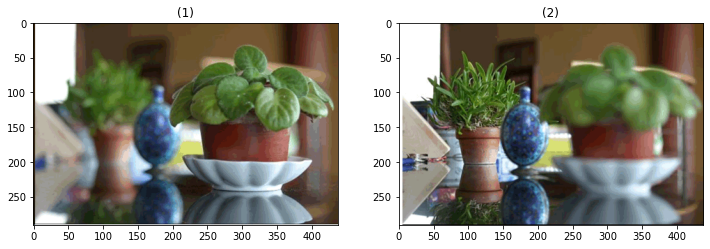

In [25]:
image = io.imread('./images/blend1.gif')
print(image.shape)
image1 = np.copy(image[:,:image.shape[1]//2 - 15,:])
image2 = np.copy(image[:,15 + image.shape[1]//2:,:])
show_images([image1, image2])

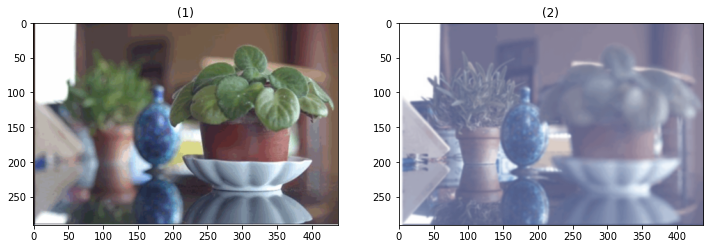

In [26]:
gaus1 = skimage.filters.gaussian(image1,sigma=0.45)
gaus2 = skimage.filters.gaussian(image2,sigma=1)
show_images([gaus1, gaus2])

In [49]:
def gaussian_pyramid(image, sigma=0.5):
    """
    construct the gaussian pyramid by down-sampling and applying gaussian filter at each stage
    :param image: input image to construct pyramid for
    :return pyramid: list on images constructing the pyramid
    """
    # the pyramid base start with the image
    _image = np.copy(image)
    pyramid = [_image]
    x, y = _image.shape[0], _image.shape[1]
    while x > 2 and y > 2:
        # apply gaussian filter then down-sample with a factor of 2
        current_img = np.copy(pyramid[-1])
        current_img = skimage.filters.gaussian(current_img, sigma=sigma)
        x, y = current_img.shape[1]//2, current_img.shape[0]//2
        current_img = cv2.resize(current_img, dsize=(x, y))
        pyramid.append(current_img)
    return pyramid

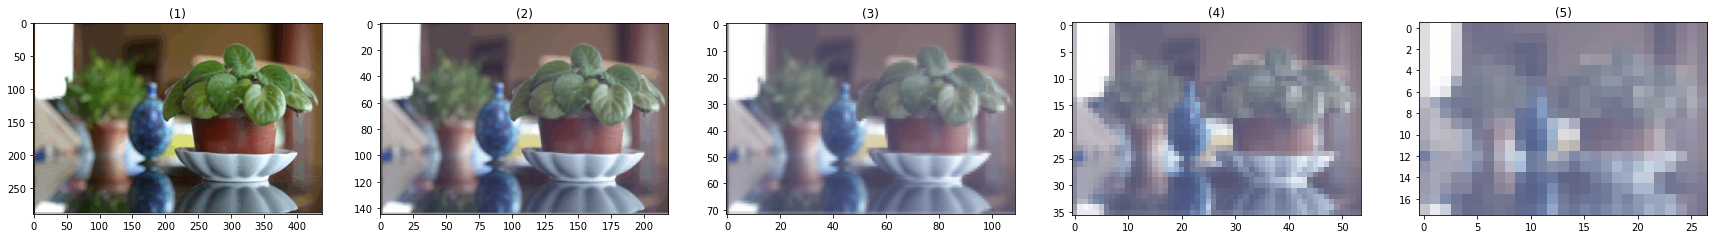

In [50]:
p = gaussian_pyramid(image1)
show_images([p[0],p[1],p[2],p[3],p[4]])

In [53]:
def laplacian_pyramid(image, sigma=0.5):
    """
    construct the laplacian pyramid by up-sampling and applying gaussian filter in image k
    then subtract it from image k-1 in the gaussian pyramid
    by this way you get the lost information due to down sampling
    :param image: input image to construct pyramid for
    :return pyramid: list on images constructing the pyramid
    """
    # first of all get the gaussian pyramid
    gaus_pyramid = gaussian_pyramid(image, sigma)
    lap_pyramid = []
    for i in range(len(gaus_pyramid)):
        # up-sample with a factor of 2 then apply gaussian filter
        # Since there is no image gN + 1 to serve as the prediction image for gN, we say LN = gN.
        if i == len(gaus_pyramid) - 1:
            lap_pyramid.append(gaus_pyramid[i])
            break
        gi = np.copy(gaus_pyramid[i])
        gi_next = np.copy(gaus_pyramid[i+1])
        # up-sampling to gi
        prediction = cv2.resize(gi_next, dsize=(gi.shape[1], gi.shape[0]))
        # apply gaussian filter
        prediction = skimage.filters.gaussian(prediction, sigma=sigma)
        lap_pyramid.append(gi - prediction)
    return lap_pyramid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


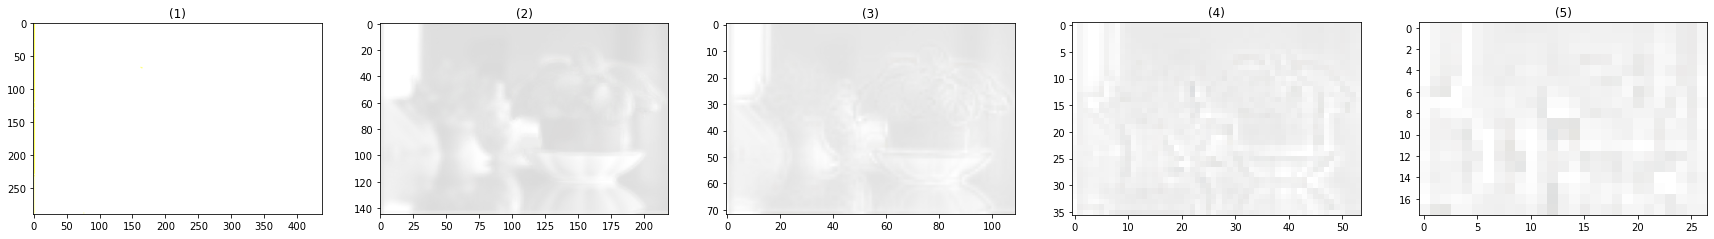

In [54]:
p = laplacian_pyramid(image1)
show_images([p[0],p[1],p[2],p[3],p[4]])